In [93]:
import numpy as np
from scipy.integrate import cumtrapz, trapz
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# import scipy.io

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=True)  # switch to False incase the notebook is slow!!!!
rcParams.update({'font.size': 18})

In [94]:
def dTdy(T,y):

    deruni = (-3*T[0]+4*T[1]-1*T[2])/2.0
    dergrid = -1/60*-y[3] + 0.15*-y[2] - 0.75*-y[1] \
              +1/60* y[3] - 0.15* y[2] + 0.75* y[1]
    der = deruni * 1/dergrid 
    return der

# Estimating mean profiles and fluxes in high-speed turbulent boundary layers using inner/outer-layer transformations

             Created on: Dec, 2023
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Asif M. Hasan (a.m.hasan@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Dec, 2023
                     by: Rene Pecnik 


### The following equations are solved iteratively in this notebook. Refer to the paper for more details.

#### Required inputs are $Re_\theta$, $M_\infty$, $T_w/T_r$ and (optionally) the dimensional wall or free-stream temperature for Sutherland's law.  It is important to note that all solver inputs are based on the quantities in the free-stream, and not at the boundary layer edge.

#### 1. Mean shear (in non-dimensional form)
\begin{equation}
    \frac{d\bar u^+}{dy^+} =  \frac{\mu_w}{\bar \mu} \frac{1}{1 + \underbrace{\kappa y^* D(M_\tau)}_{\mu_t}}  +  \frac{\sqrt{\rho_w/\bar\rho}}{Re_\tau} \, \frac{\Pi}{\kappa} \, \pi\, \sin \left(\pi \frac{y}{\delta}\right),
\end{equation}
where 
\begin{equation}\label{Dc}
D(M_{\tau}) = \left[1 - \mathrm{exp}\left({\frac{-y^*}{A^+ + f(M_\tau)}}\right)\right]^2,
\end{equation}

and 
$$A^+ = 17,~\kappa=0.41,~f(M_\tau)=19.3M_\tau,$$

and 
$${\Pi} = 0.69\,\left[1 - \exp(-0.243 \sqrt{z} - {0.15} \,z)\right],~\text{with } z = Re_\theta/425 - 1.$$

#### 2. Temperature velocity relationship (Zhang et al. (2014), JFM)
\begin{equation}
\frac{\bar T}{T_w} =1+\frac{T_r-T_w}{T_w} \left[(1-s\,{Pr})\left(\frac{\bar u^+}{u^+_\infty}\right)^2+s \, {Pr}\left(\frac{\bar u^+}{u_\infty^+}\right)\right]+\frac{T_\infty-T_r}{T_w}\left(\frac{\bar u^+}{u^+_\infty}\right)^2,
\end{equation}

where $s\,{Pr}=0.8$, $ T_r/T_\infty = 1 + 0.5 r (\gamma-1)M_\infty^2$, $r=Pr^{1/3}$ and $Pr=0.72$.

#### 3. Density profile (using ideal gas equation of state)
\begin{equation}
\frac{\bar\rho}{\rho_w} = \frac{T_w}{\bar T}
\end{equation}

#### 4. Viscosity profile (using Sutherland's law)
\begin{equation}
\frac{\bar\mu}{\mu_w}=\left(\frac{\bar T}{T_w}\right)^{3 / 2} \frac{T_w+S}{\bar T+S},
\end{equation}
where S = 110.56 K

#### 5. Computing $Re_\tau$ and $M_\tau$ using the inputs $Re_\theta$ and $M_\infty$
\begin{equation}
Re_\tau = {Re_\theta}\frac{ \mu_\infty/\mu_w}{(\rho_\infty/\rho_w) u_\infty^+ (\theta/\delta)}
\end{equation}

\begin{equation}
M_\tau = M_\infty \sqrt{\frac{c_f}{2}}
\end{equation}

In [95]:
# Constants
gamma     = 1.4
Pr        = 0.72
kappa     = 0.41
Apl       = 17

In [96]:
def grid(H,n,fact):
    tanhyp = 0.5
    i = tanhyp*(np.arange(0,n))/(n-1) - 0.5
    y = 1./tanhyp*H * (1.0 + np.tanh(fact*i)/np.tanh(fact/2))/2.0
    
    return y

In [97]:
def temperature(upl, Minf, Tw_Tr):

    r = Pr**(1/3)
    Tr_Tinf = 1 + r*(gamma - 1)/2*Minf**2
    Tinf_Tw = 1/(Tw_Tr*Tr_Tinf)        
    al   = 0.8
    u_uinf = upl/upl[-1] #*0.99
    f_u  = (1 - al)*(u_uinf)**2 + al*(u_uinf)
    T_Tw = 1 + (1/Tw_Tr - 1)*f_u + (Tinf_Tw - 1/Tw_Tr)*(u_uinf)**2
    
    return T_Tw

In [98]:
def viscosity(T_Tw, viscLaw, Tinf_dim):

    if viscLaw == "Sutherland":
        Tinf_Tw = T_Tw[-1]/T_Tw[0]
        S     = 110.56/Tinf_dim * Tinf_Tw
        mu    = T_Tw**(1.5)*(1 + S)/(T_Tw + S)
        mu_muw = mu/mu[0]

    elif viscLaw == "PowerLaw":
        mu_muw = T_Tw**0.75

    else:
        print('Viscosity law ', viscLaw, " not available")
    
    return mu_muw

In [99]:
def density(T_Tw):
        
    r_rw = 1/T_Tw

    return r_rw

In [100]:
def meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw, upl):
    
    ReTauSt = ReTau*np.sqrt(r_rw)/mu_muw   # semi-local Reynolds number
    ypl     = y_ye*ReTau                   # y+
    yst     = y_ye*ReTauSt                 # semi-local wall distance y*    
    
    z1  = ReTheta/425-1
    Pi   = 0.69*(1 - np.exp(-0.243*z1**0.5 - 0.150*z1))

    D = (1-np.exp(-yst/(Apl + 19.3*MTau)))**2
    
    upl       =   cumtrapz(mu_muw**-1/(1 + kappa*yst*D), ypl, initial=0) \
                + cumtrapz(1/ReTau/np.sqrt(r_rw)*Pi/kappa*np.pi*np.sin(np.pi*y_ye), ypl, initial=0)   
    
#     upl[y_ye>1] = upl[np.sum(y_ye<=1)]/0.99 #Since velocity at the edge is 0.99 times velocity in the free-stream
    
    return ypl, yst, upl

In [101]:
def calcParameters(ReTheta, y_ye, r_rw, mu_muw, upl, Minf, T_Tw, Tw_Tr):
    
    uinf          = upl[-1]/0.99
    Theta         = trapz(r_rw/r_rw[-1]*upl/uinf*(1 - upl/uinf), y_ye)
    ReTheta_ReTau = r_rw[-1]*uinf*Theta/mu_muw[-1]
    ReTau         = ReTheta/ReTheta_ReTau
    cf            = 2/(r_rw[-1]*uinf**2)
    ch            = 1/ReTau/Pr*dTdy(T_Tw,y_ye)/(r_rw[-1]*uinf*(Tw_Tr**-1 -1))        
    MTau          = Minf*(cf/2)**0.5    
    
#     Theta         = trapz(r_rw/r_rw[-1]*upl/upl[-1]*(1 - upl/upl[-1]), y_ye)
#     ReTheta_ReTau = r_rw[-1]*upl[-1]*Theta/mu_muw[-1]
#     ReTau         = ReTheta/ReTheta_ReTau
#     cf            = 2/(r_rw[-1]*upl[-1]**2)
#     ch            = 1/ReTau/Pr*dTdy(T_Tw,y_ye)/(r_rw[-1]*upl[-1]*(Tw_Tr**-1 -1))        
#     MTau          = Minf*(cf/2)**0.5    

    
    return ReTau, MTau, cf, ch

In [102]:
def Solver(ReTheta = 1000, Minf = 1.0, Tw_Tr = 1.0,    
                  viscLaw = "Sutherland", Tinf_dim = 300):
    
    # Generate grid
    y_ye = grid(1, 360, 5)  # (domain size, number of cells, stretching factor)
    
    # set initial values for ReTau, MTau and upl
    ReTau = 100
    MTau  = 0.0
    upl   = np.ones_like(y_ye)*0.1

    niter = 0
    err   = 1e10
    
    while(err > 1e-10 and niter < 1000):

        ReTauOld = ReTau
        
        T_Tw                 = temperature(upl, Minf, Tw_Tr)
        mu_muw               = viscosity(T_Tw, viscLaw, Tinf_dim)
        r_rw                 = density (T_Tw) 
        ypl, yst, upl        = meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw, upl)        
        ReTau, MTau, cf, ch  = calcParameters(ReTheta, y_ye, r_rw, mu_muw, upl, Minf, T_Tw, Tw_Tr)

        err = abs(ReTauOld-ReTau)
        niter += 1

    return cf, ch, ReTau, MTau, ypl, yst, upl, T_Tw, niter

## Plotting

Convergence reached after 24 iterations.

Skin friction coefficient cf = 7.18636e-04 
Heat Transfer coefficient ch = 4.02245e-04


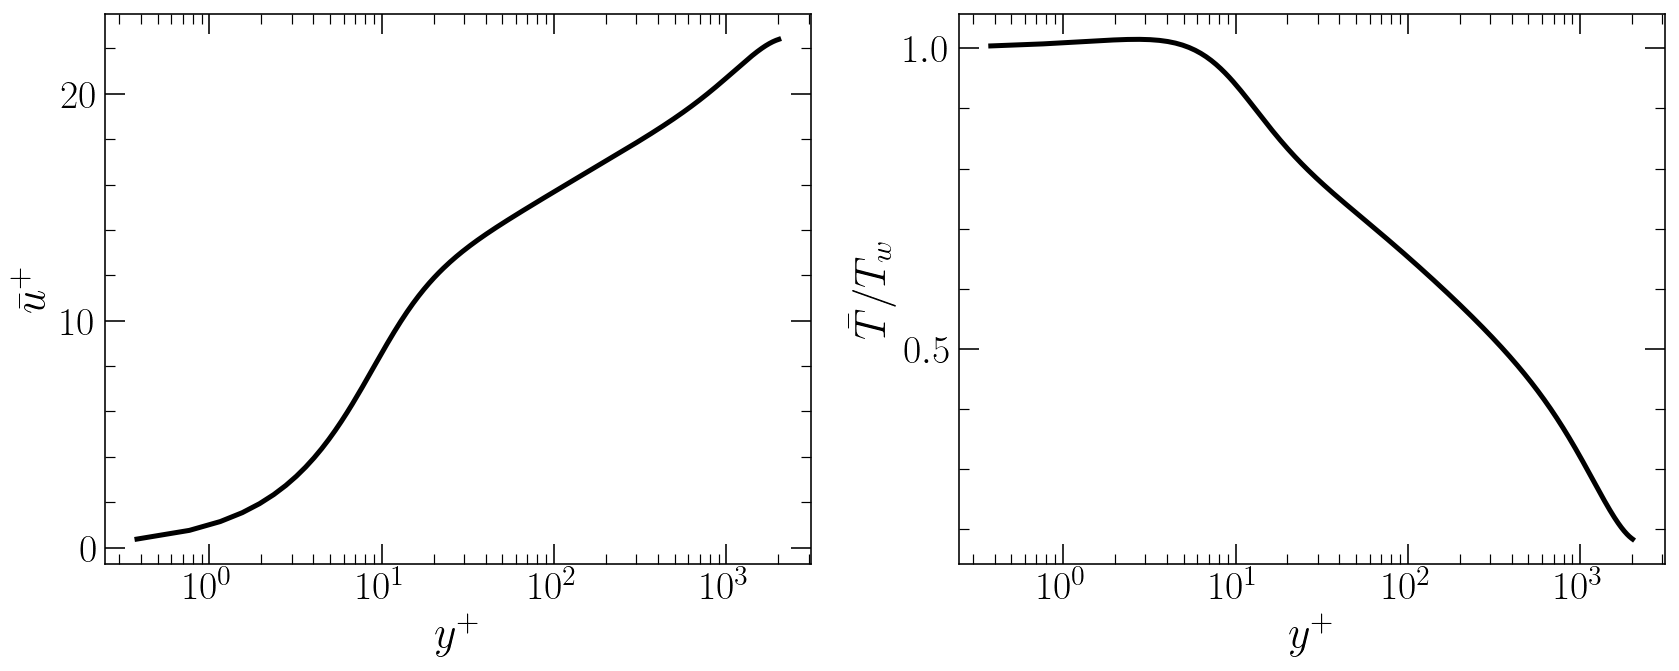

In [103]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes,InsetPosition,mark_inset)

fig, [ax, ax2]= plt.subplots(1,2,figsize=(12,5))               
Minf      = 5.86
ReTheta   = 40774.6527128768
Tw_Tr     = 0.76
viscLaw   = "Sutherland"
Tinf_dim    = 100

cf,ch,ReTau,MTau,ypl,yst,upl,T, niter = Solver(ReTheta=ReTheta, Minf=Minf, Tw_Tr=Tw_Tr,
                                           viscLaw=viscLaw, Tinf_dim=Tinf_dim)


ax.semilogx(ypl[(ypl>0) & (ypl<ReTau)], upl[(ypl>0) & (ypl<ReTau)],lw=2.5, color = 'k', fillstyle='none', linestyle='-')
ax2.semilogx(ypl[(ypl>0) & (ypl<ReTau)], T[(ypl>0) & (ypl<ReTau)],lw=2.5, color = 'k', fillstyle='none', linestyle='-')

ax.set_ylabel(r"$\bar u^+$",fontsize = 22)
ax2.set_ylabel(r"$\bar T/T_w$",fontsize = 22)
ax.set_xlabel(r"$y^+$",fontsize = 22)
ax2.set_xlabel(r"$y^+$",fontsize = 22)

ax.tick_params(axis='both', which='both', direction='in',labelsize=20,right=True, top=True,bottom=True)
ax2.tick_params(axis='both', which='both', direction='in',labelsize=20,right=True, top=True,bottom=True)

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(axis='both', which='major', size=10)
ax.tick_params(axis='both', which='minor', size=5)
ax2.tick_params(axis='both', which='major', size=10)
ax2.tick_params(axis='both', which='minor', size=5)


plt.tight_layout()

print('Convergence reached after {0} iterations.'.format(niter))
print('\nSkin friction coefficient cf = {0:.5e} \nHeat Transfer coefficient ch = {1:.5e}'.format(cf, ch))


# Compare with DNS

In [106]:
import pandas as pd
DNS = pd.read_csv("DataForDragAndHeatTransfer.csv")
groups = DNS.groupby(by='Author', as_index=True)
DNS

,Author,Minf,Red2,ReTheta,Tw_Tr,ViscLaw,Tinf,cf_DNS,ch_DNS
0,Zhang et al. [19],2.50,1667.468967,2850.067224,1.00,Sutherland,270.0,0.002312,inf
1,Zhang et al. [19],5.86,1816.680802,9175.435339,0.76,Sutherland,55.0,0.000998,0.000583
2,Zhang et al. [19],5.84,1097.366244,2052.651751,0.25,Sutherland,55.2,0.001704,0.001002
3,Zhang et al. [19],7.87,1958.173161,9552.219288,0.48,Sutherland,51.8,0.000766,0.000441
4,Zhang et al. [19],13.64,2333.279583,14301.773000,0.18,Sutherland,47.4,0.000404,0.000226
5,Bernandini and Pirozzoli [20],2.00,580.005975,920.935152,1.00,Sutherland,169.4,0.003422,NaN
6,Bernandini and Pirozzoli [20],2.00,1387.662592,2200.721638,1.00,Sutherland,169.4,0.002762,NaN
7,Bernandini and Pirozzoli [20],2.00,1910.760966,3030.632593,1.00,Sutherland,169.4,0.002535,NaN
8,Bernandini and Pirozzoli [20],2.00,3152.515323,5000.447780,1.00,Sutherland,169.4,0.002240,NaN
9,Bernandini and Pirozzoli [20],2.00,4010.313231,6362.664644,1.00,Sutherland,169.4,0.002105,NaN


In [107]:
groups.count()

,Minf,Red2,ReTheta,Tw_Tr,ViscLaw,Tinf,cf_DNS,ch_DNS
Author,,,,,,,,
"A. Ceci, private communication",2,2,2,2,2,2,2,2
Bernandini and Pirozzoli [20],9,9,9,9,9,9,9,0
Ceci et al. [22],6,6,6,6,6,6,6,6
Cogo et al. [21],4,4,4,4,4,4,4,4
Huang et al. [38],4,4,4,4,4,4,4,4
Zhang et al. [19],5,5,5,5,5,5,5,5


<ipython-input-101-53984f247184>:8: RuntimeWarning: invalid value encountered in scalar divide
  ch            = 1/ReTau/Pr*dTdy(T_Tw,y_ye)/(r_rw[-1]*uinf*(Tw_Tr**-1 -1))
<ipython-input-101-53984f247184>:8: RuntimeWarning: divide by zero encountered in scalar divide
  ch            = 1/ReTau/Pr*dTdy(T_Tw,y_ye)/(r_rw[-1]*uinf*(Tw_Tr**-1 -1))


rms =  4.013086646235322


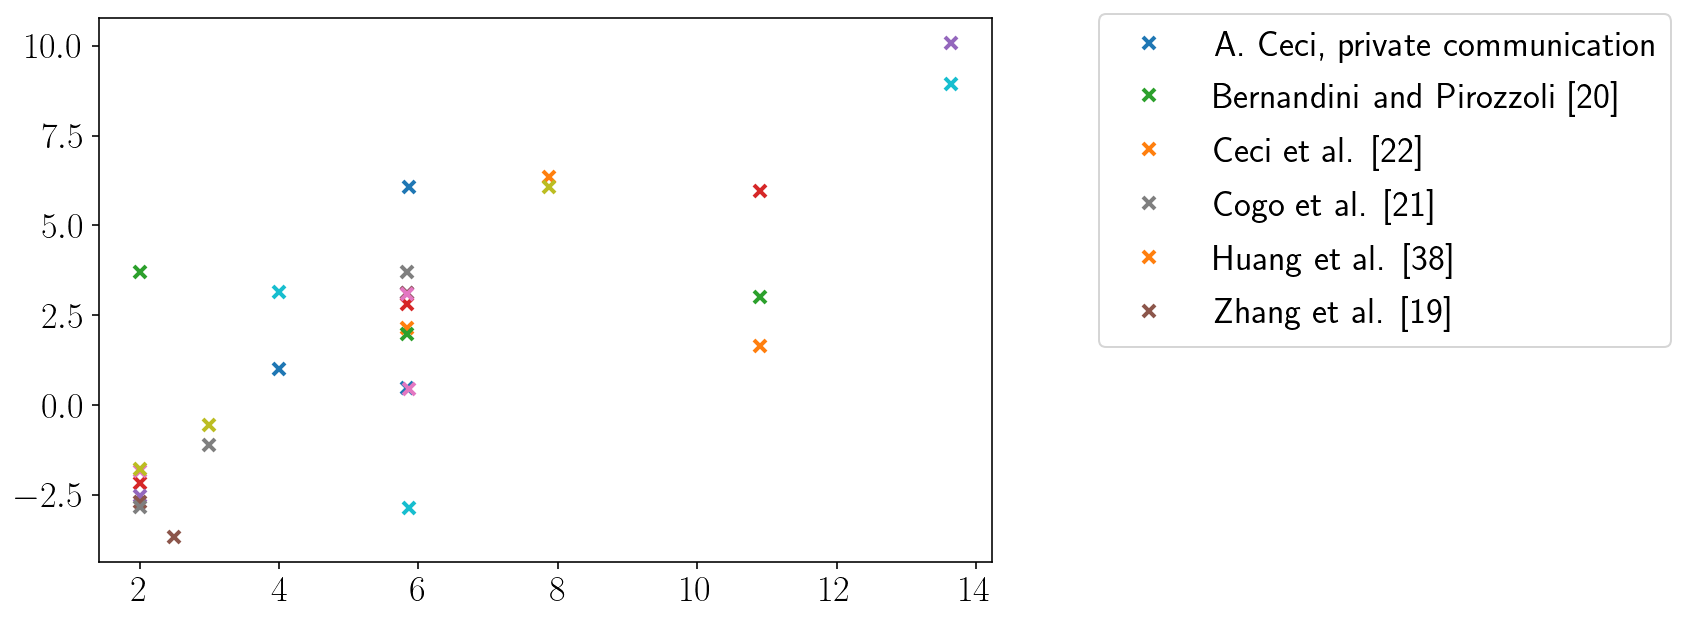

In [116]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

rms = 0.0
for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():
        
        Minf      = row['Minf']
        ReTheta = row['ReTheta']
        Tw_Tr   = row['Tw_Tr']
        viscLaw = row['ViscLaw']
        Tinf_dim  = row['Tinf']
        cf_DNS  = row['cf_DNS']
        ch_DNS  = row['ch_DNS']
        
        cf,_,_,_,_,_,_,_,_ = Solver(ReTheta=ReTheta, Minf=Minf, Tw_Tr=Tw_Tr,
                                                   viscLaw=viscLaw, Tinf_dim=Tinf_dim)

        err = (cf-cf_DNS)/cf_DNS*100
        
        rms += err**2 / DNS.count()[0]

        label = None
        if row_index == 0: 
            label = row['Author']

        ax.plot(Minf, err, marker = 'x', #row['Symbol'], color = row['Color'], ms=10*row['Size'], 
             mew=2, fillstyle='none', linestyle='None', label=label)

#         ax[1].plot(ReTheta, err, marker = row['Symbol'], color = row['Color'],
#                 ms=10*row['Size'], mew=2, fillstyle='none', linestyle='None', label=label)

#         ax[2].plot(Tw_Tr, err, marker = row['Symbol'], color = row['Color'],
#                 ms=10*row['Size'], mew=2, fillstyle='none', linestyle='None', label=label)

ax.legend(bbox_to_anchor=(1.1, 1.04))

print("rms = ", np.sqrt(rms))